# Customer Segmentation
**Problem statement:**

	•	Segment customers based on their transaction behaviour
	•	Provide insights on each segment

**About data:** 

	•	Monthly transaction history for 30 customers across 12 products Jan'2017 to Oct'2020 
	•	Total 16560 records, 5 features
	•	Fields
	•	customerId: Unique customer ID
	•	productId: Unique product ID
	•	date: Month- year combination
	•	qtyPurchased: Number of units purchased for the product
	•	transactionAmount: Transaction amount in (CAD) 



## Introduction

Customer segmentation has always been important for any business. Traditional approaches focuses on customers' profile like age, gender, demographic. However, understanding who your customers are is not enough.

The recent customer segmentation approach is not only understanding who the customers are but also what they interact with the business using insights derived from customers’ actions. It is known as `Behavioral Segmentation`. It allows businesses to divide customers into groups according to other features like use of, or response to a product, service or brand, not only according to profile like traditional approaches.

The objective here is to identify customer segments that enable you to understand how to address the particular needs so achieve what the business want.

In this assignment, given monthly transaction history for 30 customers across 12 products Jan 2017 to Oct 2020 of a business, we are asked to segment the customers into groups based on their transaction behaviour. It is also called purchase behavior-based  segmentation.

We take a standard approach to solve this data science problem. First, we gather the data and explore it. Second, we do exploratory data analysis (EDA). Then we pre-process the data and do feature selection/engineering. Next is model development & discussion. Hyper-parameter tuning & model evalution, model deployment are other steps but we leave them for the future works. 




### Step-by-step

- Gather the data
- Explore the data
- Feature selection/engineering
- Modeling
- Interpret the result
- Future works

## Gather the data

We use Goole Colab to work on the problem.

In [ ]:
# connect Google Colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# load xlsx file to pandas dataframe
df = pd.read_excel('/content/drive/MyDrive/DS4BP/Retail.xlsx')
df.head()

,customerId,productId,date,qtyPurchased,transactionAmount
0,C1,P1,2017-01-01,7,20.3436
1,C1,P1,2017-02-01,6,17.5826
2,C1,P1,2017-03-01,7,21.9440
3,C1,P1,2017-04-01,7,21.2027
4,C1,P1,2017-05-01,8,26.9709


## Explore the data

To help us to verify the description & understand more about the data.

In [ ]:
# print a concise summary of the dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16560 entries, 0 to 16559
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customerId         16560 non-null  object        
 1   productId          16560 non-null  object        
 2   date               16560 non-null  datetime64[ns]
 3   qtyPurchased       16560 non-null  int64         
 4   transactionAmount  16560 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 647.0+ KB


In [ ]:
print(df.isnull().sum())
print(df.customerId.unique())
print(df.productId.unique())
print(df.date.min(), df.date.max())

customerId           0
productId            0
date                 0
qtyPurchased         0
transactionAmount    0
dtype: int64
['C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'C10' 'C11' 'C12' 'C13'
 'C14' 'C15' 'C16' 'C17' 'C18' 'C19' 'C20' 'C21' 'C22' 'C23' 'C24' 'C25'
 'C26' 'C27' 'C28' 'C29' 'C30']
['P1' 'P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12']
2017-01-01 00:00:00 2020-10-01 00:00:00


**Note:** 

- No missing/invalid data. It is good. There are 16560 records & 5 features as described. 

- There are 30 customers labeled from `C1` to `C30`.

- There are 12 different products in the dataset labeled from `P1` to `P12`.

- Monthly transaction history from `Jan 2017` to `Oct 2020` as described.



Let's plot the total transaction amount per month of several customers (i.e., `C1`, `C10` & `C25`).

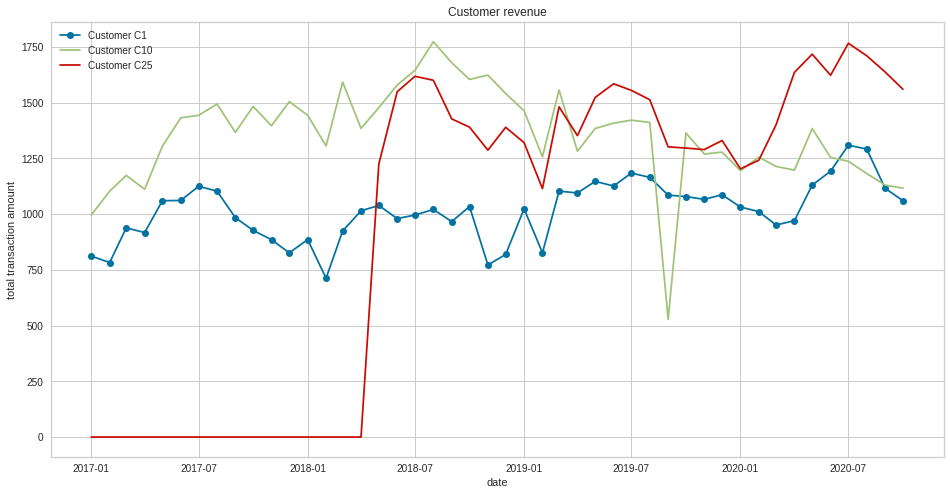

In [ ]:
# create a dictionary with 30 dataframes of 30 customers
df_customer = df.groupby(['customerId','date']).transactionAmount.sum().reset_index()

C = {}
for i in range(1, 31):
    C[i] = df_customer.loc[df_customer.customerId == 'C{}'.format(i), ['date', 'transactionAmount']]

plt.figure(figsize=(16, 8))
c1 = plt.plot(C[1].date, C[1].transactionAmount, marker='o')
c10 = plt.plot(C[10].date, C[10].transactionAmount, marker='x')
c25 = plt.plot(C[25].date, C[25].transactionAmount, marker='+')
plt.title('Customer revenue')
plt.xlabel('date')
plt.ylabel('total transaction amount')
plt.legend((c1[0], c10[0], c25[0]), ('Customer C1', 'Customer C10', 'Customer C25'))

**Note:** 

- As mentioned in the description, the dataset contains monthly transaction history for 30 customers across 12 products from Jan 2017 to Oct 2020. However, from the above plot, customer `C25` have no transaction from Jan 2017 to Apr 2018. Hypothesis: 1) customer `C25` is an old customer but have no transaction from Jan 2017 to Apr 2018; 2) customer `C25` is our new customer on May 2018 (i.e., become our customer since May 2018).

- We want to plot the transaction amount of each customer from Jan 2017 to Oct 2020 to see any other customers that have no history transaction like customer `C25`. With the plot below, we can observe that there are several customers similar to customer `C25` (i.e., there is no transaction in the first few months during the data collection period). This observation will help us to calculate the total revenue from our customers later.

Text(0, 0.5, 'total transaction amount')

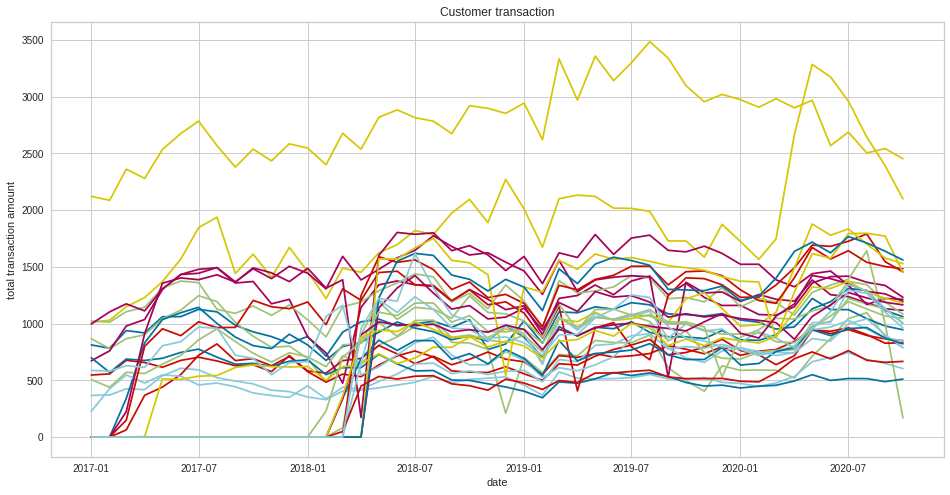

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(1, 31):
    plt.plot(C[i].date, C[i].transactionAmount)
plt.title('Customer transaction')
plt.xlabel('date')
plt.ylabel('total transaction amount')

**Note:** 

- The code below is to find the starting date of our newest customer. It is on May 2018. 

- There are two ways to calculate the total revenue from each customer later while there are several customers who have the transaction after Jan 2017: 1) we only calculate the total revenue from each customer from May 2018 to Oct 2020; or 2) we calculate the average revenue per month since they become our customers then estimate the total revenue during Jan 2017 to Oct 2020.

In [ ]:
# find the starting date of our newest customer
customer_rev = df.groupby(['customerId', 'date']).transactionAmount.sum().to_frame().reset_index()
new_customer = customer_rev[customer_rev.transactionAmount==0].date.max()
new_customer

Timestamp('2018-04-01 00:00:00')

**Note:** 

- We decide to remove all the transaction from Jan 2017 to Apr 2018 to be fair among customers when we do the segmentation. The reasons: 1) all 30 customers have the transaction from May 2018 to Oct 2020, every single month; 2) the period from May 2018 to Oct 2020 is more recent, up-to-date and long enough.

- Note that there are many different ways to deal with those. It happens in real life. We will discuss later in the furure work.

In [ ]:
# get data from May 2018 to Oct 2020
df_30m = df.loc[df.date>new_customer]
df_30m.head()

,customerId,productId,date,qtyPurchased,transactionAmount
16,C1,P1,2018-05-01,7,24.8101
17,C1,P1,2018-06-01,7,22.2431
18,C1,P1,2018-07-01,7,22.3986
19,C1,P1,2018-08-01,6,20.8793
20,C1,P1,2018-09-01,7,21.1366


We would like to see how the revenue percentage from each customer for our business.

Text(0.5, 1.0, 'total transaction amount by customer')

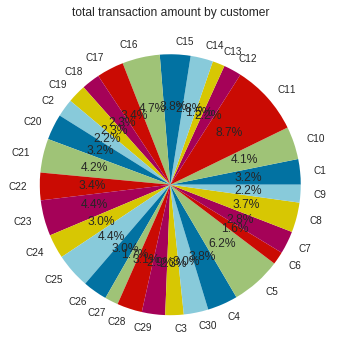

In [ ]:
df_revenue = df_30m.groupby('customerId')[['transactionAmount']].sum()

plt.figure(figsize=(12, 6))
plt.pie(df_revenue.transactionAmount, autopct="%.1f%%", labels=df_revenue.index)
plt.title('total transaction amount by customer')

**Note:** 

- From the above plot, customer `C11` is a high-value customer (i.e., generate high revenue) and customers `C13`, `C6` is a low-value customers (i.e., generate low revenue). Note that it is a relative comparision.

We would like to see the different between total purchased quantities and total transaction amount of each product.

Text(0.5, 1.0, 'transaction amount by product')

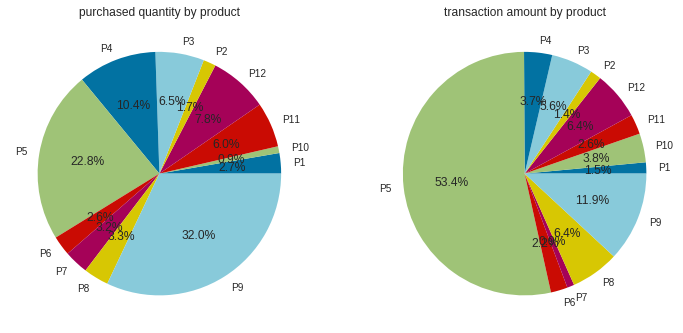

In [ ]:
df_product_qty = df_30m.groupby('productId')[['qtyPurchased']].sum()
df_product_amount = df_30m.groupby('productId')[['transactionAmount']].sum()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(df_product_qty.qtyPurchased, autopct="%.1f%%", labels=df_product_qty.index)
plt.title('purchased quantity by product')
plt.subplot(1, 2, 2)
plt.pie(df_product_amount.transactionAmount, autopct="%.1f%%", labels=df_product_amount.index)
plt.title('transaction amount by product')

**Note:** 

- From the above plot, we can observe that `P5` is a high value product and `P9` is a low value product.

We would like to see the products bought by our customers.

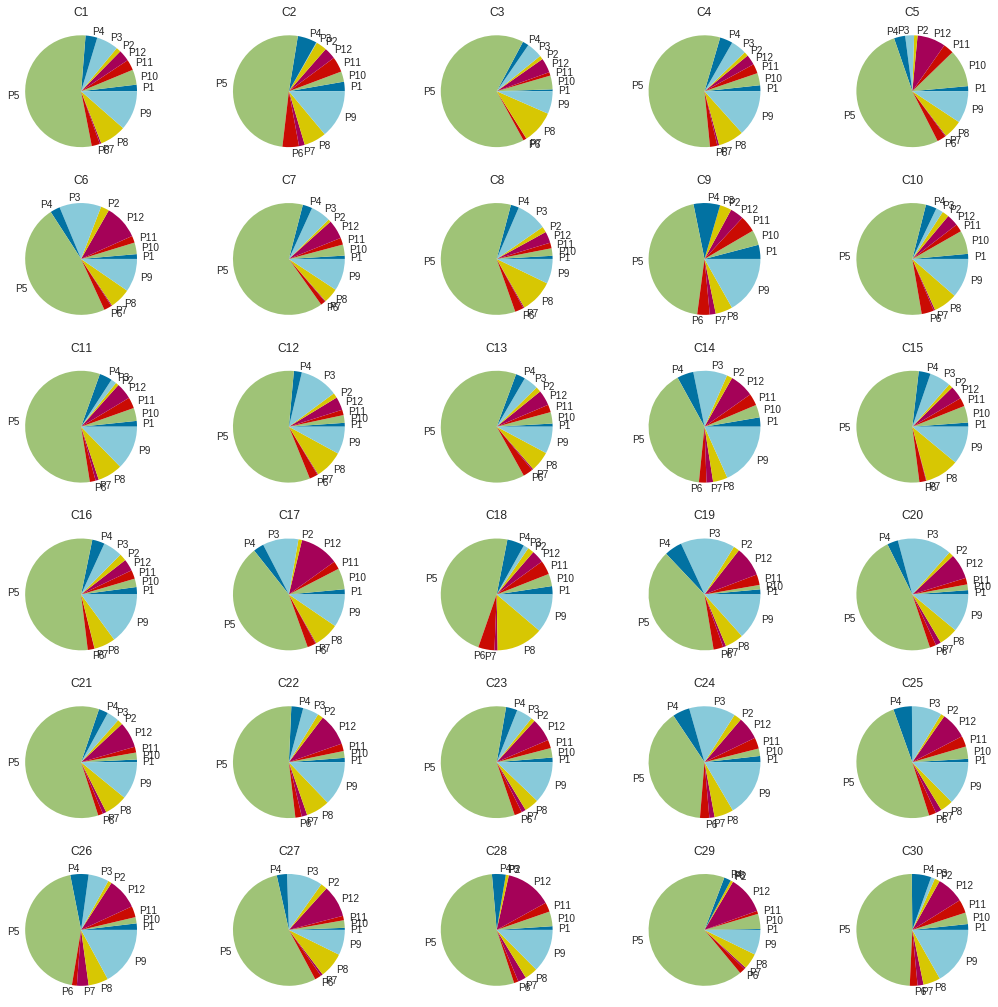

In [ ]:
df_C = {}
for i in range(1, 31):
  df_C[i] = df_30m[df_30m.customerId == 'C{}'.format(i)].groupby('productId')[['transactionAmount']].sum()

plt.figure(figsize=(18, 18))
for i in range(1, 31):
  plt.subplot(6, 5, i)
  plt.pie(df_C[i].transactionAmount, labels=df_C[i].index)
  plt.title('C{}'.format(i))
plt.show()

**Note:** 

- All the customers have spent the most of the money on Product `P5`.

- Other products may vary from customer to customer.

We would like to see how the business is doing.

Text(0, 0.5, 'total transaction amount')

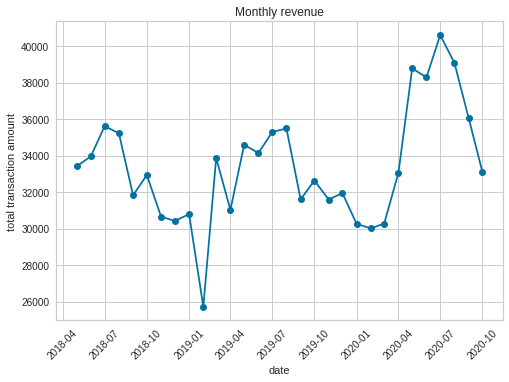

In [ ]:
monthly_revenue = df_30m.groupby('date').transactionAmount.sum().to_frame()

plt.plot(monthly_revenue.index, monthly_revenue.transactionAmount, marker='o')
plt.xticks(rotation=45)
plt.title('Monthly revenue')
plt.xlabel('date')
plt.ylabel('total transaction amount')

**Note:** 

- The business does great in summer time (May, June, July) and not good during winter time (Jan, Feb).

So far, we have a brief idea about our data. Now is the time to move to build a segmentation model with some feature selection/engineering first.

## Feature Selection/Engineering

We all know that customers who come to us have different needs, different profiles, etc. We can’t treat every customer the same way. The way we treat them really depends on what we/our business try to achieve.

With the requirement of customer segmentation based on their transaction behaviour, we need first to define what we/the business try to achieve with this segmentation. With this assignment, we can define that `what we/our business try to achieve` is total revenue from all the products. We also implement and discuss about another criteria: `what we/our business try to achieve` is the revenue from one specific product, i.e., product `P15` in this implentation. It is applicable for the case that the business would lile to increase the sale of this product.

To be more specific, the implentation is based on Recency, Frequency and Monetary Value (RFM) values. However, since Recency & Frequency (RF) values are the same in our case, we use Monetary value only.

Monetary is defined as revenue. First we calculate the total revenue from each customer from May 2018 to Oct 2020. Then we apply K-means clustering to segment our customer based on the total revenue. We ignore `productID` & `qtyPurchased` columns for now. In this part, we do not split the dataset into `training` & `validation` data. It is our future work.

### Revenue calculation

Calculate the total revenues from each customer during the period from May 2018 to Oct 2020.

In [ ]:
# calculate monetary
df_monetary = df_30m.groupby('customerId').transactionAmount.sum().reset_index()
df_monetary.columns = ['customerId', 'monetary']
df_monetary.set_index('customerId', inplace=True)

In [ ]:
df_monetary.head()

,monetary
customerId,
C1,31678.2647
C10,40712.7769
C11,87674.2536
C12,22297.7549
C13,15179.0032


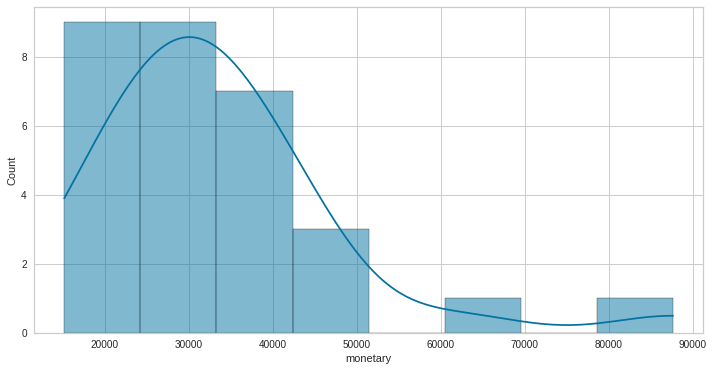

In [ ]:
# plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(df_monetary['monetary'] , kde=True)

**Note:** 

- We need to preprocess the data, i.e., reduce the skewness, normalize the data. Since there is only one feature, monetary, the preprocess step is not important/neccessary. However, we implement it here.

- Several methods can be used to manage the skewness, e.g., `log transformation`, `square root transformation`, `box-cox transformation`. We can try all these and choose the best one. In this exercise, we use cube-root transformation. Also, we normalize the data by using  `StandardScaler` function from `scikit-learn`. The code is below.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


2.0
0.9


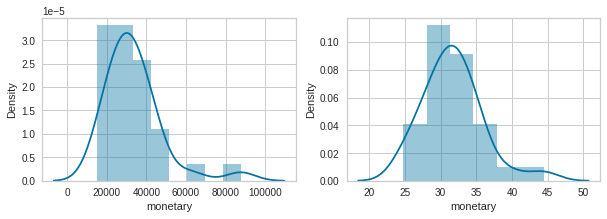

In [ ]:
# plot before and after transformation
fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(df_monetary.monetary, ax=ax[0])
sns.distplot(np.cbrt(df_monetary.monetary), ax=ax[1])

print(df_monetary.monetary.skew().round(2))
print(np.cbrt(df_monetary.monetary).skew().round(2))

In [ ]:
df_monetary.head()

,monetary
customerId,
C1,31678.2647
C10,40712.7769
C11,87674.2536
C12,22297.7549
C13,15179.0032


In [ ]:
df_monetary['monetary_transform'] = pd.Series(np.cbrt(df_monetary['monetary'])).values
df_monetary_orig = df_monetary.copy()
df_monetary.drop(columns=['monetary'], inplace=True)
scaler = StandardScaler()
scaler.fit(df_monetary)

df_monetary_normalized = scaler.transform(df_monetary)

Now it is the time to build our first segmentation model.

## Modelling

There are many different segmenation algorithm but in this excercise, we use the K-Means algorithm.

We do not detail the K-Means algorithm here. We use the `KMeans` function from `scikit-learn` to do this.

The most important hyperparameter to apply the KMeans function is the number of clusters. To find the optimal hyperparamenter, we apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia. 



In [ ]:
# from sklearn.cluster import KMeans
# import yellowbrick
# from yellowbrick.cluster import KElbowVisualizer

# model = KMeans(random_state=42, max_iter=50000, algorithm="elkan")
# visualizer = KElbowVisualizer(model, k=(1,15), locate_elbowbool=True)
# visualizer.fit(df_monetary_normalized)

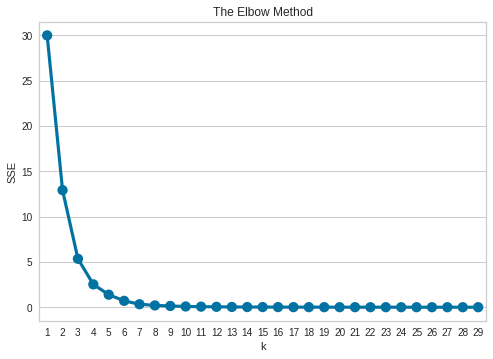

In [ ]:
# plot elbow to choose the number of clusters
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_monetary_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

**Note:** 

- From the above figure, the k-value of 5 is the reasonable hyperparameter for our model, i.e., the number of clusters is 5 in our case. Note that based on business requirements, we can have less or more clusters

- Now, we can fit the model with `k = 5`.

In [ ]:
# cluster = 5
df_monetary
model = KMeans(n_clusters=5, random_state=42)
model.fit(df_monetary_normalized)
model.labels_.shape

df_monetary["cluster"] = model.labels_
df_monetary_orig["cluster"] = model.labels_
df_monetary.head()

,monetary_transform,cluster
customerId,,
C1,31.641262,0
C10,34.401463,4
C11,44.424651,2
C12,28.146240,3
C13,24.759835,1


Now we want to plot the customers, revenues, and clusters to see the result.

Text(0.5, 1.0, 'customers, revenues, and clusters over all products')

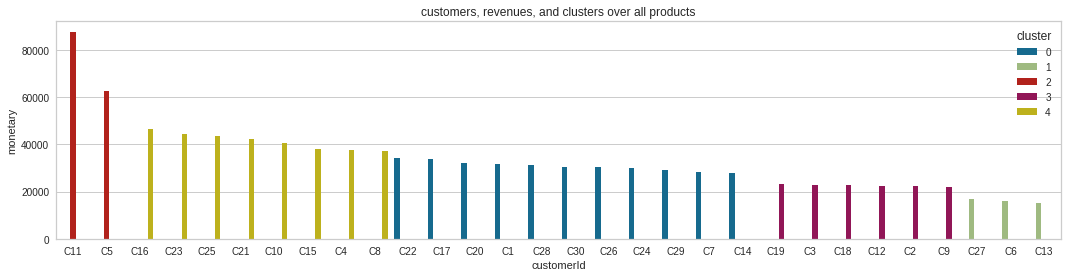

In [ ]:
# plot customers, revenues, and clusters 
df_monetary_sorted = df_monetary_orig.sort_values('monetary', ascending=False)
#df_monetary_sorted = df_monetary.sort_values('monetary_transform', ascending=False)
df_monetary_sorted.reset_index(inplace=True)
plt.figure(figsize=(18,4))
sns.barplot(x=df_monetary_sorted.customerId, y=df_monetary_sorted.monetary, hue=df_monetary_sorted.cluster)
plt.title('customers, revenues, and clusters over all products')

Characteristics of our clusters look like below:

In [ ]:
df_monetary_sorted.groupby('cluster')['monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,11.0,30817.903945,2017.772781,27968.7224,29502.712500,30511.97130,31903.349750,34141.7641
1,3.0,15931.171867,733.468468,15179.0032,15574.563900,15970.12460,16307.256200,16644.3878
2,2.0,75023.516750,17890.843627,62372.7799,68698.148325,75023.51675,81348.885175,87674.2536
3,6.0,22541.228233,418.403172,22011.7546,22270.816250,22525.08570,22780.359100,23133.9334
4,8.0,41272.283712,3505.790541,37061.6183,37912.016750,41403.11315,43818.028375,46635.9944


## Discussion

- We segment our customers to 5 groups according to the revenue. We can see how our monetary (revenue) clusters have different characteristics. The customers in Cluster 2 (2 customers, `C11` & `C5`) generate the highest revenue compared to other clusters. Meanwhile the customers in Cluster 1 (3 customers, `C27`, `C6` and `C13`) generate the lowest revenue compared to other clusters. This result agree with our observation in the data exploration step. With the current output of `KMeans` function from `scikit-learn`, we could not say Cluster 0 is the worst and cluster 4 is the best. It is ugly for now but we can implement a function to re-arrange the order to make the output neater. 

- We can label those five groups as: 1) Very-high value group (cluster 2), 2) High value group (cluster 4), 3) Middle value group (cluster 0), 4) Low value group (cluster 2), 5) Very-low value group (cluster 1). Based on business requirements, we can have less or more clusters. For example, we can regroup into three groups:  1) High value group (cluster 2), 2) Middle value group (cluster 0, 3, 4), 3) Low value group (cluster 1).

- It is helpful for our business with the above segmentation result. We know which customers we should invest in to generate revenue and be profitable. For example, we try to keep customers in the high value group (cluser 2) while investing more promotions, ads, survey etc in the low value group (cluser 1) to see the reason, act accordingly and turn them into valuable customers. 

- We need to validate our model, i.e., our clustering result. In practice, we can split our dataset into two group: 1) Group 1 includes the data from May 2018 to April 2020 and 2) Group 2 includes the data from May 2020 to Oct 2020. We use the data in Group 1 to apply segmentation and the data in Group 2 to revalidate the result. In practive, we need to update our model after a certain of time. We leave this part for now.

## Another Segmentation Approach

The first approach considers the total revenue as a key feature to segment our customers. However, in practice, the business may want to increase the sale of a specific product. A group of customers the business should focus on may differ from any group of customers resulted from the above segmentation approach. Again, it really depends on what we/our business try to achieve.

For example, let's look on the sale of product `P3`. The implentation is similar to above but we only consider product `P3`. 


Text(0.5, 1.0, 'total transaction amount of P3 by customer')

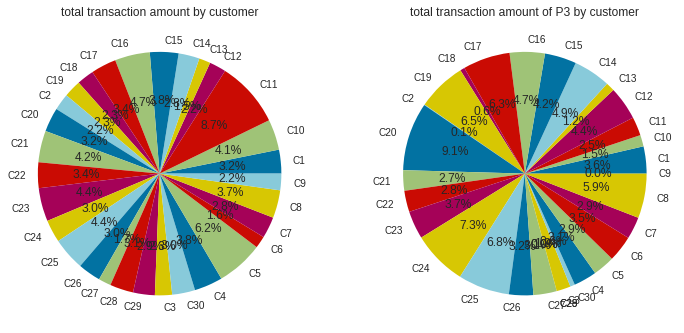

In [ ]:
df_all = df_30m
df_monetary = df_all.groupby('customerId')[['transactionAmount']].sum()

df_P3 = df_30m[df_30m.productId == 'P3']
df_monetary_P3 = df_P3.groupby('customerId')[['transactionAmount']].sum()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(df_monetary.transactionAmount, autopct="%.1f%%", labels=df_monetary.index)
plt.title('total transaction amount by customer')

plt.subplot(1, 2, 2)
plt.pie(df_monetary_P3.transactionAmount, autopct="%.1f%%", labels=df_monetary_P3.index)
plt.title('total transaction amount of P3 by customer')

**Note:**
- Let's look on the above plot. It shows us that customer `C11` has the most total transaction amount over all products but customer `C24` has the most total transaction amount over product `P3`. In other word, we should focus on customer `C24` (instead of customer `C11`) more if we still need to keep high revenue from product `P3` in the future.

Again, we apply the above segmentation algorthim to our data but only considering product `P3`.

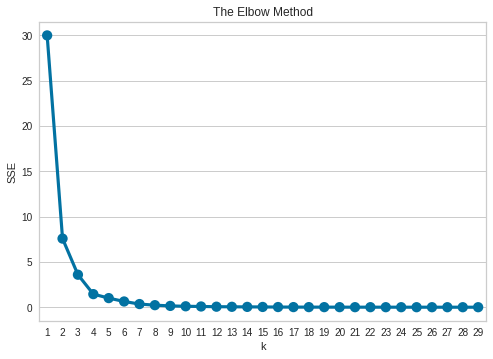

In [ ]:
# calculate monetary for P3
df_P3 = df_30m[df_30m.productId == 'P3']
df_monetary_P3 = df_P3.groupby('customerId')[['transactionAmount']].sum().reset_index()

df_monetary_P3.columns = ['customerId', 'monetary']
df_monetary_P3.set_index('customerId', inplace=True)

df_monetary_P3['monetary_transform'] = pd.Series(np.cbrt(df_monetary_P3['monetary'])).values
df_monetary_P3_orig = df_monetary_P3.copy()
df_monetary_P3.drop(columns=['monetary'], inplace=True)
scaler = StandardScaler()
scaler.fit(df_monetary_P3)

df_monetary_P3_normalized = scaler.transform(df_monetary_P3)

# plot elbow to choose the number of clusters
sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_monetary_P3_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

From the above figure, the k-value can be chosen of 4. For comparasion purpose with the first approach, we choose the number of clusters of 5 in this case.

Now, we can fit the model with k = 5.

In [ ]:
# cluster = 5
model = KMeans(n_clusters=5, random_state=42)
model.fit(df_monetary_P3_normalized)
model.labels_.shape

df_monetary_P3["cluster"] = model.labels_
df_monetary_P3_orig["cluster"] = model.labels_
df_monetary_P3.head()

,monetary_transform,cluster
customerId,,
C1,12.609383,4
C10,9.455107,3
C11,11.130008,0
C12,13.529608,4
C13,8.644544,3


Text(0.5, 1.0, 'customers, revenues, and clusters over product `P3`')

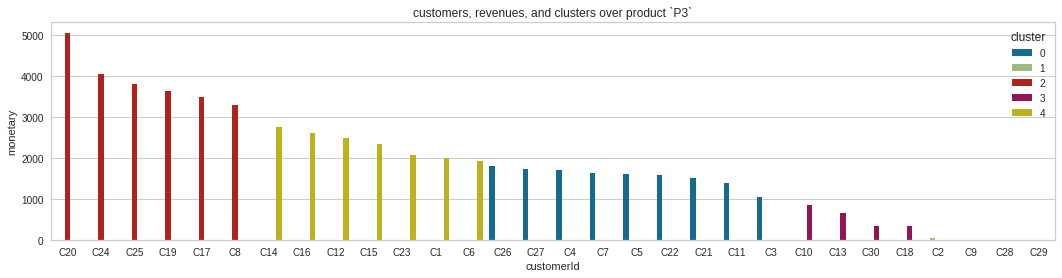

In [ ]:
# plot customers, revenues, and clusters 
df_monetary_P3_sorted = df_monetary_P3_orig.sort_values('monetary', ascending=False)
df_monetary_P3_sorted.reset_index(inplace=True)
plt.figure(figsize=(18,4))
sns.barplot(x=df_monetary_P3_sorted.customerId, y=df_monetary_P3_sorted.monetary, hue=df_monetary_P3_sorted.cluster)
plt.title('customers, revenues, and clusters over product `P3`')

Text(0.5, 1.0, 'customers, revenues, and clusters over all products')

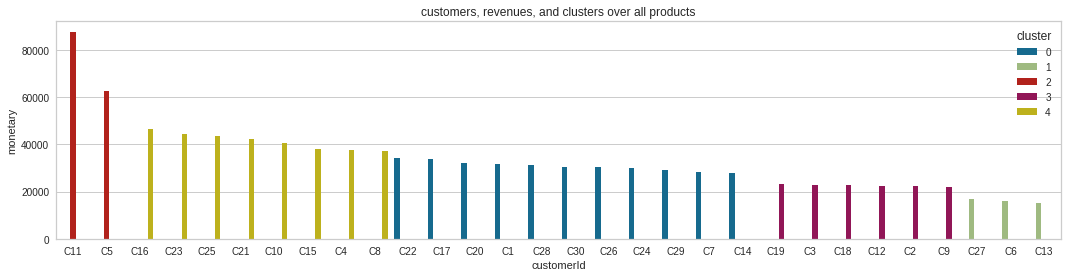

In [ ]:
# re-plot customers, revenues, and clusters over all products
plt.figure(figsize=(18,4))
sns.barplot(x=df_monetary_sorted.customerId, y=df_monetary_sorted.monetary, hue=df_monetary_sorted.cluster)
plt.title('customers, revenues, and clusters over all products')

In [ ]:
df_monetary_P3_sorted.tail()

,customerId,monetary,monetary_transform,cluster
25,C18,335.9400,6.951639,3
26,C2,39.5495,3.407064,1
27,C9,0.1177,0.490071,1
28,C28,0.0000,0.000000,1
29,C29,0.0000,0.000000,1


**Note:** 

- From the above plots, we can observe that customers `C28` & `C29` do not buy product `P3` from us. There are some reasons: 1) they do not know that we have product `P3`, or 2) they do not need product `P3`.  Meanwhile, those customers are valueable customers if we consider the total revenue from all the products. We may target to those customers to have more sales on product `P3`.

- Customer `C19` is a very high-value customer for product `P3` but just a low-value customer for all the products.

- Customers `C11` & `C5` are belong to very-high value customer group for all the products but just a mid-value customer for product `P3`.

- Consider product `P3` as an example, one can apply to consider other products as well.

Again it really matters what our business tries to achieve so we can segment our customers to different groups accordingly. Customers who come to us have different needs and different profile. We should adapt our actions. 

## Predictive Behavioral Segments

We go back to a very basic question: why do we need customer segmentation? There are many reasons. One of the reason is to help the business market/target to each group of customers effectively and appropriately, **in the future**, not in the past.

The above approaches basically assume that the future is similar to the past, i.e., we use historical data to do the segmentation. Also, we only consider the total revenue from May 2018 to Oct 2010 as a key feature. We have not taken into account the patterns of behavior displayed by customers. 

Looking at only the total revenue from each customer isn’t enough. If we have a high-spending customer who bought a lot stuffs with a lot of money but never came back. The current algorithm may consider this customer as a high valuable customer but it is not true. On the other hand, if we have a customer who spend enough, and keep coming back that will actually be our high value customer. 

In this section, we take another approach. Based on the historical transaction data, we will build a machine learning model to predict/identify future purchases of our customers. Then we segment the customers based on the future data.

ARIMA models are an approach to time series forecasting.

Deep learning for time series forecasting is a very good candiate for solving this problem. In this excercise, we employ [Facebook Prophet](https://github.com/facebook/prophet)  to simply the implementation. `Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.` 

Below is the implementation. Basically we will employ Facebook Prophet to predict the revenue from each customer in the next 12 months, i.e., from Nov 2020 to Oct 2021. Then we calculate the total revenue from each customer and apply K-means segmentation to group customers into different groups.



In [ ]:
import fbprophet

In [ ]:
# Apply Facebook Prophet to predict the revenue in the next 12 months for 31 customer
%%time
forecast = {}
for i in range(1, 31):
  C[i] = C[i].rename(columns={'date': 'ds', 'transactionAmount': 'y'})
  model = fbprophet.Prophet().fit(C[i])
  future_df = model.make_future_dataframe(periods=12, freq='M')
  forecast[i] = model.predict(future_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

CPU times: user 1min 12s, sys: 1.58 s, total: 1min 13s
Wall time: 1min 14s


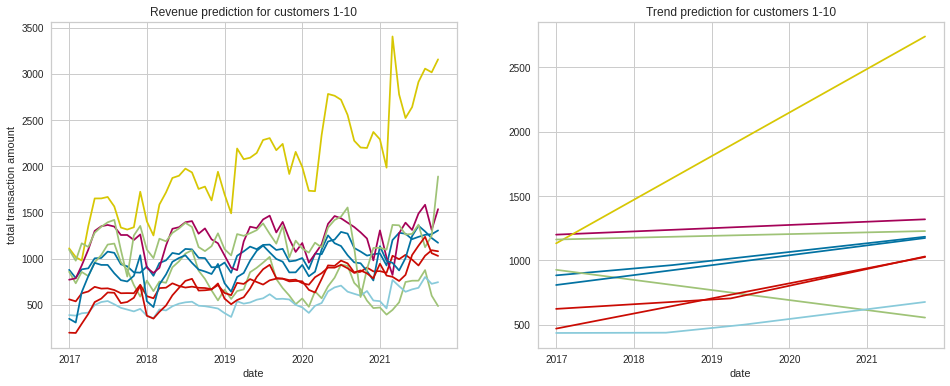

In [ ]:
# revenue and trend of customers C1-C10 in the next 12 months
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for i in range(1,10):
  plt.plot(forecast[i].ds, forecast[i].yhat)
  plt.title('Revenue prediction for customers 1-10')
  plt.xlabel('date')
  plt.ylabel('total transaction amount')
plt.subplot(1, 2, 2)  
for i in range(1,10):
  plt.plot(forecast[i].ds, forecast[i].trend)
  plt.title('Trend prediction for customers 1-10')
  plt.xlabel('date')

In [ ]:
# revenue prediction for 30 customers in the next 12 months (Nov 2020 to Oct 2021)
predict_revenue = {}
for i in range(1, 31):
  predict_revenue[i] = forecast[i].iloc[-12:, -1].sum()

predict_revenue = pd.DataFrame(predict_revenue, ['predict_12m']).transpose()
predict_revenue['cusomterId'] = ['C{}'.format(i) for i in range(1, 31)]

In [ ]:
# apply K-means: for comparision purpose, we still use 5 clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(predict_revenue[['predict_12m']])
predict_revenue['cluster'] = kmeans.predict(predict_revenue[['predict_12m']])
predict_revenue.groupby('cluster').predict_12m.describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,4.0,14709.786360,536.577898,14071.205394,14368.169374,14775.556233,15117.173219,15216.827579
1,5.0,28215.555685,2546.013497,25848.162599,26876.596072,27115.870164,28919.594788,32317.554801
2,3.0,6795.589792,1278.811322,5404.075333,6233.746209,7063.417085,7491.347021,7919.276958
3,10.0,19440.686555,1320.000051,17622.060616,18351.841123,19525.084786,20165.799554,22070.280385
4,8.0,11627.265927,991.308218,9828.375624,11138.209941,11749.125446,12388.288484,12846.166405


Text(0.5, 1.0, 'customers, revenues, and clusters over all products - prediction based')

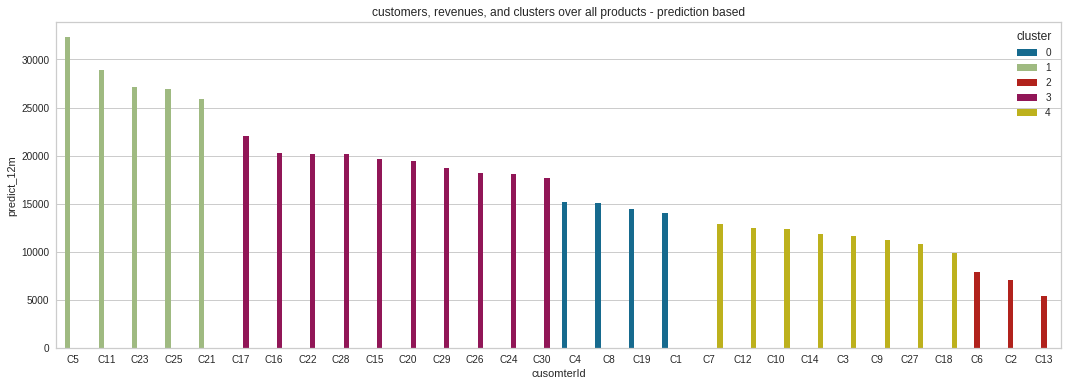

In [ ]:
# plot customers, revenues, and clusters over all products based on the prediction data in the next 12 months
predict_revenue = predict_revenue.sort_values('predict_12m', ascending=False)

plt.figure(figsize=(18,6))
sns.barplot(x=predict_revenue.cusomterId, y=predict_revenue.predict_12m, hue=predict_revenue.cluster)
plt.title('customers, revenues, and clusters over all products - prediction based')

Text(0.5, 1.0, 'customers, revenues, and clusters over all products - historical data')

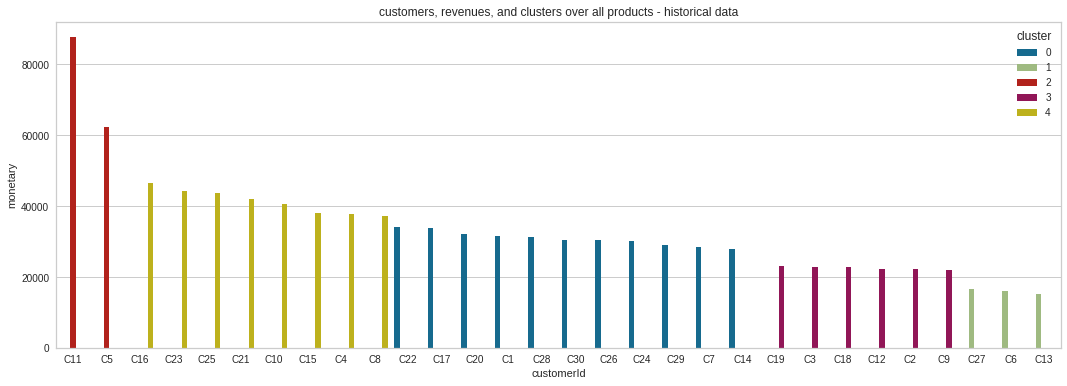

In [ ]:
# re-plot customers, revenues, and clusters over all products
plt.figure(figsize=(18,6))
sns.barplot(x=df_monetary_sorted.customerId, y=df_monetary_sorted.monetary, hue=df_monetary_sorted.cluster)
plt.title('customers, revenues, and clusters over all products - historical data')

**Note:**

- Use the same feature, the total transaction amount, but we can observe the difference in segmention results between using historical data and using predictive data. Which one is better? It is hard to mention at this point but we can validate the models by using validation strategies.

- In the past, customer `C11` is the most valuable customer but in the next 12 months, customer `C5` will bypass customer `C11` in term of the total transaction amount. For sure it will be very helpful for our business to have this kind of data.

- Within 30 customers, based on the historical data, Customer `C1` ranks 14th in generating the revenue for the business. However, in the next 12 months, Customer `C1` will rank 19th. It helps the business in personalized marketing for example.

- Facebook Prophet provides trend prediction as well.

- We can use this strategy to predict revenue from a specific product. Similar to the previous section, we target to our customer's needs.

- One can apply different deep learning algorithms to improve the accuracy of the prediction model. It results in more accurate in segmentation.

In [ ]:
# relative_trend = {}
# for i in range(1, 31):
#   relative_trend[i] = forecast[i].trend.pct_change()[1:]

# relative_trend = pd.DataFrame(relative_trend).transpose()
# relative_trend['forecast_trend'] = relative_trend.iloc[:, -12:].sum(axis=1)
# relative_trend['cusomterId'] = ['C{}'.format(i) for i in range(1, 31)]

# abs_trend = {}
# for i in range(1, 31):
#   abs_trend[i] = forecast[i].trend.diff(1)[1:]

# abs_trend = pd.DataFrame(abs_trend).transpose()
# abs_trend['forecast_trend'] = abs_trend.iloc[:, -12:].sum(axis=1)
# abs_trend['cusomterId'] = ['C{}'.format(i) for i in range(1, 31)]

# kmeans = KMeans(n_clusters=5)
# kmeans.fit(relative_trend[['forecast_trend']])
# relative_trend['trend_cluster'] = kmeans.predict(relative_trend[['forecast_trend']])
# relative_trend.groupby('trend_cluster').forecast_trend.describe()

# kmeans = KMeans(n_clusters=5)
# kmeans.fit(abs_trend[['forecast_trend']])
# abs_trend['trend_cluster'] = kmeans.predict(abs_trend[['forecast_trend']])
# abs_trend.groupby('trend_cluster').forecast_trend.describe()

# relative_trend = relative_trend.sort_values('forecast_trend', ascending=False)
# abs_trend = abs_trend.sort_values('forecast_trend', ascending=False)

# plt.figure(figsize=(18,6))
# plt.subplot(1, 2, 1)
# plt.xticks(rotation=45)
# sns.barplot(x=relative_trend.cusomterId, y=relative_trend.forecast_trend, hue=relative_trend.trend_cluster)
# plt.title('relative forcast trend')
# plt.subplot(1, 2, 2)
# sns.barplot(x=abs_trend.cusomterId, y=abs_trend.forecast_trend, hue=abs_trend.trend_cluster)
# plt.xticks(rotation=45)
# plt.title('absolute forecast trend')

## Future Works

- Utilize as much as data as possible, not only the transaction data from May 2018 to October 2020.

- Validation work: since we do not have future transaction data, we can use our historical transaction data for validation. Using data from May 2018 to April 2020  for training and the data from May 2020 to Oct 2020 for validation is one option.

- Use the most recent deep learning for time series forecasting algorithms to have more accurate prediction data. Then segment the customers based on the predictive data.

- Implement more features for the segmentation algorithms: customer lifetime value prediction, churn prediction, sale prediction, next purchase data etc.

- We have not used the column named `qtyPurchased` in our model yet. We consider to use this information.

- Consider the transaction of each product, not all products. This will provide more insight & more information for the business.

- Beside using the most recent deep learning for time series forecasting, ARIMA models are a good approach to time series forecasting. It is worth to try.
